# Scale 분석

압연공정에서의 scale불량의 원인을 찾고 개선을 위한 최적의 조건 도출


[분석 기법]

1. 그래프를 활용한 탐색적 분석
2. 로지스틱 회귀분석
3. 의사결정 트리
4. 앙상블 모델(Random Forest, Gradient Boosting)
5. KNN

## 패키지 불러오기

In [53]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import export_graphviz
from sklearn.neighbors import KNeighborsClassifier
import graphviz

## 한글 폰트 적용

In [2]:
# "맑은 고딕"을 한글 폰트로 지정
font_location = "C:/Windows/Fonts/malgunbd.ttf"
# 폰트이름 가져오기
font_name = matplotlib.font_manager.FontProperties(fname = font_location).get_name()
# 지정한 폰트를 기본 폰트로 지정
matplotlib.rc("font", family = font_name)

## 데이터 불러오기

In [3]:
ds_scale = pd.read_csv("D://WORK/DATA/SCALE불량.CSV", engine = "python")
ds_scale.head()

,PLATE_NO,ROLLING_DATE,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,...,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,PB562774,2008-08-01:00:00:15,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,116,1133,59,282,1133,934,적용,8,2조
1,PB562775,2008-08-01:00:00:16,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,122,1135,53,283,1135,937,적용,8,2조
2,PB562776,2008-08-01:00:00:59,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1129,116,1121,55,282,1121,889,적용,8,3조
3,PB562777,2008-08-01:00:01:24,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1152,125,1127,68,316,1127,885,적용,8,3조
4,PB562778,2008-08-01:00:01:44,양품,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,...,1140,134,1128,48,314,1128,873,적용,8,1조


## EDA

히스토그램

In [4]:
def fun_plot_hist(data, var):
    plt.hist(data[data["SCALE"] == "양품"][var], label = "양품", alpha = 0.5)
    plt.hist(data[data["SCALE"] == "불량"][var], label = "불량", alpha = 0.5)
    plt.legend()

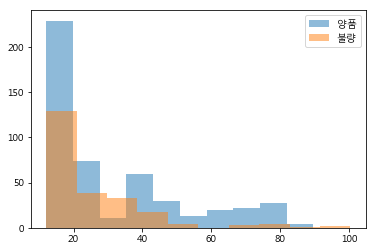

In [5]:
# plate 두께
fun_plot_hist(ds_scale, "PT_THK")

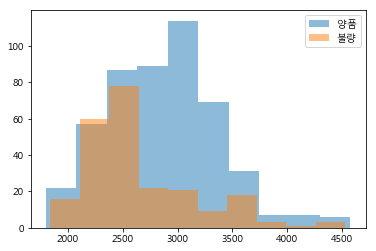

In [6]:
# plate 폭
fun_plot_hist(ds_scale, "PT_WDTH")

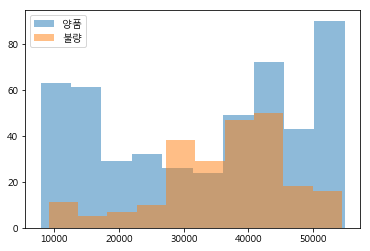

In [7]:
# plate 길이
fun_plot_hist(ds_scale, "PT_LTH")

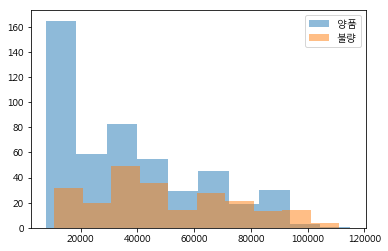

In [8]:
# plate 중량
fun_plot_hist(ds_scale, "PT_WGT")

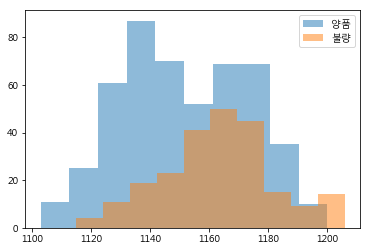

In [9]:
# 가열로 가열대 온도
fun_plot_hist(ds_scale, "FUR_HZ_TEMP")

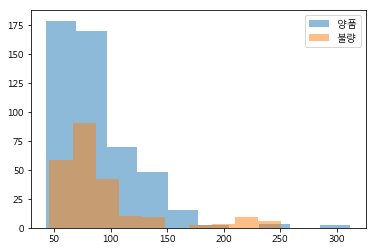

In [10]:
# 가열로 균열대 시간
fun_plot_hist(ds_scale, "FUR_HZ_TIME")

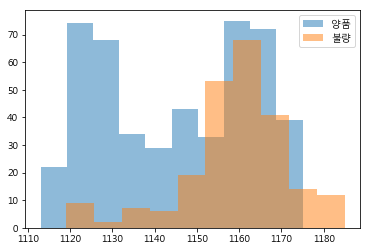

In [11]:
# 가열로 균열대 온도
fun_plot_hist(ds_scale, "FUR_SZ_TEMP")

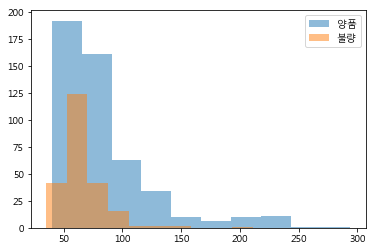

In [12]:
# 가열로 균열대 시간
fun_plot_hist(ds_scale, "FUR_SZ_TIME")

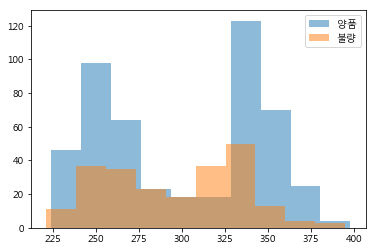

In [13]:
# 가열로 시간
fun_plot_hist(ds_scale, "FUR_TIME")

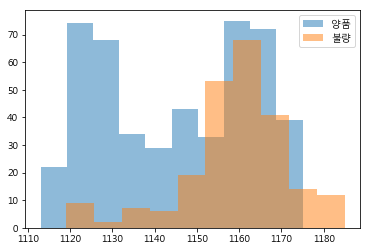

In [14]:
# 압연 온도
fun_plot_hist(ds_scale, "FUR_EXTEMP")

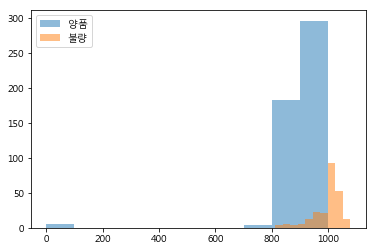

In [15]:
# 가열대 온도
fun_plot_hist(ds_scale, "ROLLING_TEMP_T5")

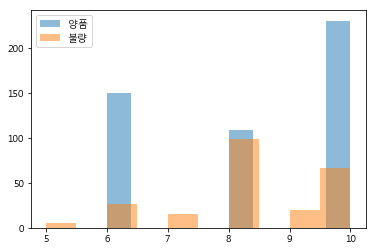

In [16]:
# 압연 중 Descaling 횟수
fun_plot_hist(ds_scale, "ROLLING_DESCALING")

교차표

In [17]:
def fun_print_crosstab(data, var):
    print(pd.crosstab(index = data["SCALE"], columns = data[var]))
    print()
    print(pd.crosstab(index = data["SCALE"], columns = data[var], normalize = "columns").round(3))

In [18]:
# 가열로 호기
fun_print_crosstab(ds_scale, "FUR_NO")

FUR_NO  1호기  2호기  3호기
SCALE                
불량       73   70   88
양품      167  167  155

FUR_NO    1호기    2호기    3호기
SCALE                      
불량      0.304  0.295  0.362
양품      0.696  0.705  0.638


In [19]:
# HSB 적용
fun_print_crosstab(ds_scale, "HSB")

HSB    미적용   적용
SCALE          
불량      33  198
양품       0  489

HSB    미적용     적용
SCALE            
불량     1.0  0.288
양품     0.0  0.712


In [20]:
# 작업조
fun_print_crosstab(ds_scale, "WORK_GR")

WORK_GR   1조   2조   3조   4조
SCALE                      
불량        67   45   54   65
양품       122  120  118  129

WORK_GR     1조     2조     3조     4조
SCALE                              
불량       0.354  0.273  0.314  0.335
양품       0.646  0.727  0.686  0.665


## 데이터 목표변수 형변환(문자형 -> 숫자형)

In [21]:
ds_scale["SCALE"].replace(to_replace = "양품", value = 0, inplace = True)
ds_scale["SCALE"].replace(to_replace = "불량", value = 1, inplace = True)
ds_scale["SCALE"].head()

0    0
1    0
2    0
3    0
4    0
Name: SCALE, dtype: int64

# 로지스틱

## train / test 데이터 분할

In [22]:
msk = np.random.rand(ds_scale.shape[0]) < 0.7
ds_scale_train = ds_scale[msk]
ds_scale_test = ds_scale[~msk]

# train 데이터와 test 데이터 크기
print("train data size : {}".format(ds_scale_train.shape))
print("test data size : {}".format(ds_scale_test.shape))

train data size : (502, 21)
test data size : (218, 21)


## 로지스틱 회귀분석

In [23]:
log_model = sm.Logit.from_formula("""SCALE ~ PT_THK + PT_WDTH + PT_LTH + PT_WGT + C(FUR_NO) + 
                                  FUR_NO_ROW + FUR_HZ_TEMP + FUR_HZ_TIME + FUR_SZ_TEMP + FUR_SZ_TIME + 
                                  FUR_TIME + FUR_EXTEMP + ROLLING_TEMP_T5 + C(HSB) + ROLLING_DESCALING + C(WORK_GR) + 1""" ,
                                  ds_scale_train)

# 적합
log_result = log_model.fit()
# 결과 출력
print(log_result.summary())

         Current function value: 0.267887
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  SCALE   No. Observations:                  502
Model:                          Logit   Df Residuals:                      483
Method:                           MLE   Df Model:                           18
Date:                Mon, 11 Feb 2019   Pseudo R-squ.:                  0.5740
Time:                        17:53:03   Log-Likelihood:                -134.48
converged:                      False   LL-Null:                       -315.71
                                        LLR p-value:                 5.948e-66
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          -105.2941   1.97e+04     -0.005      0.996   -3.87e+04    3.85e+04
C(FUR_NO)[T.2호기]     -0.3287      0.406     

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


## 예측

In [24]:
# 로지스틱 모델로 test 데이터 예측
y_pred = log_result.predict(ds_scale_test)
# 0과 1의 값을 가진 class로 변환
y_pred_class = (y_pred > 0.5).astype(int)
# 상위 10건 출력
y_pred_class.head(10)

1     0
5     0
7     0
11    0
13    0
19    0
20    0
24    0
25    0
26    0
dtype: int32

## 평가

In [25]:
# 실제 test 데이터의 목표변수와 test 데이터의 예측값 비교
print("Accuracy: {0:.3f}".format(metrics.accuracy_score(ds_scale_test["SCALE"], y_pred_class)))

Accuracy: 0.867


## 데이터 Scaling

In [26]:
# 연속형 변수
conti_varname = ds_scale.select_dtypes("int64").columns.tolist()
conti_varname.remove("SCALE")
print(conti_varname)

['PT_WDTH', 'PT_LTH', 'PT_WGT', 'FUR_NO_ROW', 'FUR_HZ_TEMP', 'FUR_HZ_TIME', 'FUR_SZ_TEMP', 'FUR_SZ_TIME', 'FUR_TIME', 'FUR_EXTEMP', 'ROLLING_TEMP_T5', 'ROLLING_DESCALING']


In [27]:
# 목표변수 형 변환 (문자형 --> 숫자형)
ds_scale["SCALE"].replace(to_replace = "양품", value = 0, inplace = True)
ds_scale["SCALE"].replace(to_replace = "불량", value = 1, inplace = True)
ds_scale["SCALE"].head()

0    0
1    0
2    0
3    0
4    0
Name: SCALE, dtype: int64

Scale 변환

In [28]:
scaler = StandardScaler()
ds_conti_scaled = scaler.fit_transform(ds_scale[conti_varname])
ds_conti_scaled = pd.DataFrame(ds_conti_scaled, columns = conti_varname)

dummy 변수

In [29]:
dummy_varname = ["FUR_NO", "HSB", "WORK_GR"]
ds_dummy = pd.get_dummies(ds_scale[dummy_varname])
X = pd.concat([ds_conti_scaled, ds_dummy], axis = 1)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, ds_scale["SCALE"], test_size = 0.3, random_state = 1234)

# 의사결정나무

## 최적의 parameter 구하기

In [31]:
model = DecisionTreeClassifier()
param_grid = {"criterion": ["gini", "entropy"],
              "max_depth": [depth for depth in range(2, 5)],
              "min_samples_split": [sample_split for sample_split in range(2, 31)],
              "min_samples_leaf": [sample_leaf for sample_leaf in range(2, 11)]}

grid_dt = GridSearchCV(model, param_grid, scoring="accuracy", n_jobs = -1)
grid_dt.fit(X_train, y_train)

print("best estimator model: \n{}".format(grid_dt.best_estimator_))
print("\nbest parameter: \n{}".format(grid_dt.best_params_))
print("\nbest score: \n{}".format(grid_dt.best_score_.round(3)))

best estimator model: 
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

best parameter: 
{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2}

best score: 
0.964


In [32]:
dt_final = DecisionTreeClassifier(criterion = "entropy", max_depth = 4, min_samples_leaf = 2, min_samples_split = 2)
dt_final.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [33]:
# df_model.feature_importances_로 설명변수 중요도 확인
ds_feature_importance = pd.DataFrame()
ds_feature_importance["feature"] = X_train.columns
ds_feature_importance["importance"] = dt_final.feature_importances_
ds_feature_importance.sort_values(by="importance", ascending=False)

,feature,importance
10,ROLLING_TEMP_T5,0.610858
16,HSB_적용,0.181471
6,FUR_SZ_TEMP,0.156655
11,ROLLING_DESCALING,0.051016
19,WORK_GR_3조,0.000000
18,WORK_GR_2조,0.000000
17,WORK_GR_1조,0.000000
15,HSB_미적용,0.000000
14,FUR_NO_3호기,0.000000
13,FUR_NO_2호기,0.000000


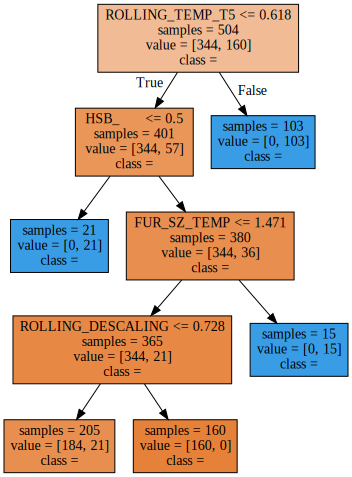

In [34]:
# 트리 모델을 tree.dot 파일로 저장
export_graphviz(dt_final, out_file="tree.dot", class_names= ["양품", "불량"],
                feature_names = X_train.columns, impurity=False, filled=True)

# graphviz를 이용해 트리 모델 시각화
with open("tree.dot", "rt", encoding="utf-8") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

## Random Forest

In [39]:
model = RandomForestClassifier()
param_grid = {"criterion": ["gini", "entropy"],
              "max_depth": [depth for depth in range(3, 11)],
              "min_samples_leaf": [sample_leaf for sample_leaf in range(10, 21)]}

grid_dt = GridSearchCV(model, param_grid, scoring="accuracy", n_jobs = -1)
grid_dt.fit(X_train, y_train)

print("best estimator model: \n{}".format(grid_dt.best_estimator_))
print("\nbest parameter: \n{}".format(grid_dt.best_params_))
print("\nbest score: \n{}".format(grid_dt.best_score_.round(3)))

best estimator model: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=11, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

best parameter: 
{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 11}

best score: 
0.899


In [43]:
rf_final = RandomForestClassifier(criterion = "entropy", max_depth = 3, min_samples_leaf = 11, n_estimators = 500)
rf_final.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=11, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [45]:
# rf_model.feature_importances_로 설명변수 중요도 확인
ds_feature_importance = pd.DataFrame()
ds_feature_importance["feature"] = X_train.columns
ds_feature_importance["importance"] = rf_final.feature_importances_
ds_feature_importance.sort_values(by="importance", ascending=False)

,feature,importance
10,ROLLING_TEMP_T5,0.346680
6,FUR_SZ_TEMP,0.131435
9,FUR_EXTEMP,0.120021
0,PT_WDTH,0.062863
7,FUR_SZ_TIME,0.055954
1,PT_LTH,0.050572
11,ROLLING_DESCALING,0.042759
16,HSB_적용,0.039027
15,HSB_미적용,0.036837
2,PT_WGT,0.031825


## Gradient Boosting

In [50]:
model = GradientBoostingClassifier()
param_grid = {"learning_rate": [rate / 10 for rate in range(1, 5)],
              "max_depth": [depth for depth in range(3, 11)],
              "min_samples_leaf": [sample_leaf for sample_leaf in range(10, 21)]}

grid_dt = GridSearchCV(model, param_grid, scoring="accuracy", n_jobs = -1)
grid_dt.fit(X_train, y_train)

print("best estimator model: \n{}".format(grid_dt.best_estimator_))
print("\nbest parameter: \n{}".format(grid_dt.best_params_))
print("\nbest score: \n{}".format(grid_dt.best_score_.round(3)))

best estimator model: 
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=10, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

best parameter: 
{'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 10}

best score: 
0.976


In [51]:
gb_final = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 4, min_samples_leaf = 10)
gb_final.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=10, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [52]:
# gb_model.feature_importances_로 설명변수 중요도 확인
ds_feature_importance = pd.DataFrame()
ds_feature_importance["feature"] = X_train.columns
ds_feature_importance["importance"] = gb_final.feature_importances_
ds_feature_importance.sort_values(by="importance", ascending=False)

,feature,importance
11,ROLLING_DESCALING,0.346758
10,ROLLING_TEMP_T5,0.278477
9,FUR_EXTEMP,0.051702
15,HSB_미적용,0.041449
16,HSB_적용,0.036970
2,PT_WGT,0.035698
6,FUR_SZ_TEMP,0.032456
7,FUR_SZ_TIME,0.030789
4,FUR_HZ_TEMP,0.027547
0,PT_WDTH,0.026936


## KNN

In [55]:
# 최대 군집 생성 개수
n_iter_neighbor = 50
neighbor_range = [i+1 for i in range(n_iter_neighbor)]
train_accuracy = []; test_accuracy = []
for n_neighbor in neighbor_range:
    knn = KNeighborsClassifier(n_neighbors = n_neighbor)
    knn.fit(X_train, y_train)
    # 각 데이터로부터 가장 가까운 군집 중심점까지 거리 제곱합
    train_accuracy.append(knn.score(X_train, y_train))
    test_accuracy.append(knn.score(X_test, y_test))

In [56]:
ds_accuracy = pd.DataFrame({"NumberOfNeighbors": neighbor_range, "TrainAccuracy": train_accuracy, "TestAccuracy": test_accuracy})
ds_accuracy.round(3)

,NumberOfNeighbors,TrainAccuracy,TestAccuracy
0,1,1.000,0.782
1,2,0.881,0.787
2,3,0.903,0.810
3,4,0.853,0.819
4,5,0.867,0.843
5,6,0.851,0.838
6,7,0.851,0.829
7,8,0.841,0.829
8,9,0.855,0.843
9,10,0.841,0.829


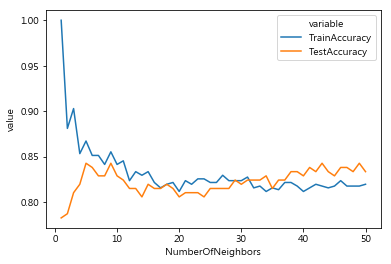

In [57]:
ds_accuracy_melt = pd.melt(ds_accuracy, id_vars = "NumberOfNeighbors")
sns.lineplot(x = "NumberOfNeighbors", y = "value", hue = "variable", data = ds_accuracy_melt)